In [1]:
import cli
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import emulators

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from emulators import autocalc_lengthscale_bounds, vary_ndims
from matplotlib import cm

plt.style.reload_library()
plt.style.use('science')

data_dir           =  '../data/processed-emulator-inputs/'

### Dicts to prettify figure labels

In [2]:
label_map = {
    'r_o': '$r_o$',
    'r_a': '$r_o$',
    'p'  : '$p$',
    'k'  : '$k$',
    'ptrans_log10'            : '$\log_{10} p_{trans}$',
    'death_rate_log10'        : '$\log_{10} p_{death}$',
    'pcure_log10'             : '$\log_{10} p_{cure}$',
    'p_infected_initial_log10': '$\log_{10} p_{infected}$'
}

response_labels = {
    'sir'      : 'Peak infection date',
    'couzin'   : 'Group direction',
    'kauffman' : 'Hamming distance'
}

ds_names = {
    'sir':'SIR',
    'couzin':'Couzin',
    'kauffman':'Kauffman'
}

### Specifying indices of process variables for 2D response surfaces

`(0,1)` indicates that the first and second columns will be allowed to vary; all other columns will be held constant to create a 2D domain interpolating over the extrema of the first two columns.

In [3]:
pairs = {
    'kauffman' : [(0,1)],
    'couzin'   : [(0,1)],
    'sir'      : [(0,1),(1,2), (2,3)]
}

y_preds   = {}
varied_Xs = {}

### Applying emulator for process variables

In [4]:
methods            = ['map','mcmc',  'vi']
model_type         = 'process'
datasets           = ['sir', 'kauffman', 'couzin']
white_noise        = True
response_transform = 'none'


for dataset in datasets:
    input_filepath    = f'{data_dir}/{dataset}.json'
    for fit_method in methods:
        run_string = f'{dataset}_{model_type}_{fit_method}'
        input_filepath = f'{data_dir}/{dataset}.json'

        inputs =  cli.prep_data(input_filepath, model_type, 
                        response_transform='none',
                        train_only=False)

        kron_Xs, y, offset, scale, input_scales, input_offsets, train, test = inputs

        Xs = kron_Xs[0]
        Xs_train = Xs[train]
        Xs_test  = Xs[test]

        y_scale = y.max()
        y_std = y / y_scale

        y_train, y_test = y_std[train], y_std[test]

        n_params = Xs_train.shape[1]
        lower, upper = [x[0] for x in autocalc_lengthscale_bounds(kron_Xs)]
        print(f'Length scale bounds for {dataset} dataset: {lower} - {upper}')

        y_preds[dataset+'_'+fit_method]   = []
        varied_Xs[dataset+'_'+fit_method] = []

        with pm.Model() as model:
            mean        = pm.Normal('mean', sd=1)
            gp_scale    = pm.HalfNormal('gp_scale', sd=1.0)
            gp_variance = pm.Deterministic('gp_variance', gp_scale**2)
            mean_func   = pm.gp.mean.Constant(mean)

            ls     = pm.Uniform('ls', lower=lower, upper=upper)
            sigma  = pm.HalfNormal('sigma', sd=1.)
            cov_fn = gp_variance * pm.gp.cov.Matern52(n_params, ls=ls, active_dims=np.arange(n_params))

            gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_fn)
            _  = gp.marginal_likelihood('ll', Xs_train, y_train, noise=sigma, is_observed=True)

            if fit_method == 'mcmc':
                trace = pm.sample(chains=4, cores=4, tune=2000)
            elif fit_method == 'map':
                trace = pm.find_MAP()
            elif fit_method == 'vi':
                approx = pm.fit(n=100_000)
                trace = approx.sample()
            else:
                raise ValueError

        for pair in pairs[dataset]:
            X_varying = vary_ndims(Xs, pair, resolution=20)

            if fit_method == 'map':
                point = trace
            else:
                point = {x: trace[x].mean(axis=0) for x in trace.varnames}

            # .predict has a weird API; even if you give it a trace full of
            # samples it will only pull a single one at a time instead of
            # sampling over the whole trace. We'll give it a point
            # estimate here.
            raw_mean, raw_var = gp.predict(X_varying, diag=True, point=point)
            print(raw_mean.max(), y_scale, scale, offset)
            mean = raw_mean * scale*y_scale + offset
            var  = raw_var  * (scale*y_scale) **2
            y_preds[dataset+'_'+fit_method] += [(mean, var)]
            varied_Xs[dataset+'_'+fit_method] += [X_varying*input_scales + input_offsets]

2022-02-21 13:51:42 CRITICAL Response variable with shape (200,) standardized with mapping none, scale=79 and offset=0


Length scale bounds for sir dataset: 0.022360679774997897 - 3.3541019662496847



0.5076981901610469 1.0 79 0
0.35536525397617313 1.0 79 0


2022-02-21 13:52:19 CRITICAL Response variable with shape (200,) standardized with mapping none, scale=79 and offset=0


0.38887201185742715 1.0 79 0
Length scale bounds for sir dataset: 0.022360679774997897 - 3.3541019662496847


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_78244/1697775674.py:50: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-21 13:52:20 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-21 13:52:20 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-02-21 13:52:26 INFO     Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-21 13:52:26 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNIN

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 181 seconds.
2022-02-21 13:55:27 INFO     Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 181 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-21 13:55:32 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-21 13:55:32 ERROR    There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-21 13:55:32 ERROR    There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-21 13:55:32 ERROR    There were 3 divergences after tuning. Increase `target_acce

0.5410547216611306 1.0 79 0
0.38087968994971055 1.0 79 0


2022-02-21 13:55:35 CRITICAL Response variable with shape (200,) standardized with mapping none, scale=79 and offset=0


0.3860072699106476 1.0 79 0
Length scale bounds for sir dataset: 0.022360679774997897 - 3.3541019662496847


Finished [100%]: Average Loss = -31.972
2022-02-21 13:59:39 INFO     Finished [100%]: Average Loss = -31.972


0.5427597750139633 1.0 79 0
0.37942564203966994 1.0 79 0


2022-02-21 13:59:42 CRITICAL Response variable with shape (100,) standardized with mapping none, scale=0.4337 and offset=0.0


0.38609771355194156 1.0 79 0
Length scale bounds for kauffman dataset: 0.014142135623730952 - 2.121320343559643


2022-02-21 13:59:45 CRITICAL Response variable with shape (100,) standardized with mapping none, scale=0.4337 and offset=0.0


0.9773851299996468 1.0 0.4337 0.0
Length scale bounds for kauffman dataset: 0.014142135623730952 - 2.121320343559643


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_78244/1697775674.py:50: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-21 13:59:46 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-21 13:59:46 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-02-21 13:59:50 INFO     Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-21 13:59:50 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNIN

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 53 seconds.
2022-02-21 14:00:43 INFO     Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 53 seconds.
2022-02-21 14:00:45 CRITICAL Response variable with shape (100,) standardized with mapping none, scale=0.4337 and offset=0.0


0.9795024039511251 1.0 0.4337 0.0
Length scale bounds for kauffman dataset: 0.014142135623730952 - 2.121320343559643


Finished [100%]: Average Loss = -47.096
2022-02-21 14:01:35 INFO     Finished [100%]: Average Loss = -47.096
2022-02-21 14:01:36 CRITICAL Response variable with shape (121,) standardized with mapping none, scale=0.029180208725843114 and offset=0.005789343102955035


0.979233051455742 1.0 0.4337 0.0
Length scale bounds for couzin dataset: 0.014142135623730952 - 2.121320343559643


2022-02-21 14:01:39 CRITICAL Response variable with shape (121,) standardized with mapping none, scale=0.029180208725843114 and offset=0.005789343102955035


0.998191783648475 1.0 0.029180208725843114 0.005789343102955035
Length scale bounds for couzin dataset: 0.014142135623730952 - 2.121320343559643


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_78244/1697775674.py:50: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-21 14:01:40 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-21 14:01:40 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-02-21 14:01:44 INFO     Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-21 14:01:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNIN

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 96 seconds.
2022-02-21 14:03:19 INFO     Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 96 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-21 14:03:21 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-21 14:03:21 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-21 14:03:21 INFO     The number of effective samples is smaller than 25% for some parameters.
2022-02-21 14:03:22 CRITICAL Response variable with shape (121,) standardized with mapping none, scale=0.029180208725843114 and offset=0.005789343102955035


0.9943899408416272 1.0 0.029180208725843114 0.005789343102955035
Length scale bounds for couzin dataset: 0.014142135623730952 - 2.121320343559643


Finished [100%]: Average Loss = -114.92
2022-02-21 14:05:03 INFO     Finished [100%]: Average Loss = -114.92


0.9953035571115114 1.0 0.029180208725843114 0.005789343102955035


### Side-by-side plots of MCMC only

In [5]:
azim_rotations = {
    'couzin' : 190
}

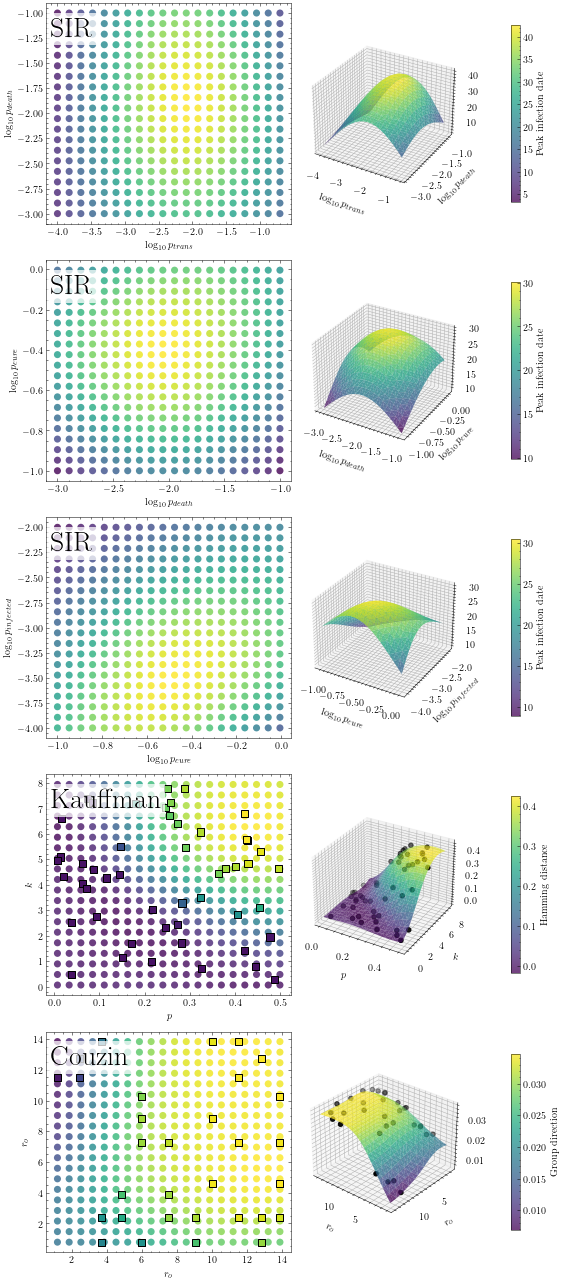

In [6]:
save_fig = True

ctr  = 1
fig  = plt.figure(figsize=(8,18))
cmap = 'viridis'
fit_method = 'mcmc'
for dataset in datasets:
    
    with open(f'../data/processed-emulator-inputs/{dataset}.json', 'r') as src:
        json_dict = json.loads(src.read())
        process_names = json_dict['process_names']
            
    for (mean, variance), X_varying, pair in zip(y_preds[dataset+'_'+fit_method],
                                                 varied_Xs[dataset+'_'+fit_method],
                                                 pairs[dataset]):
        
        ax_3d = fig.add_subplot(5, 2, ctr*2, projection='3d')
        plt.sca(ax_3d)
        
        Xs = X_varying[:, pair[0]]
        Ys = X_varying[:, pair[1]]
        Zs = mean
        
        surf = ax_3d.plot_trisurf(Xs, Ys, Zs, cmap=cmap, linewidth=0, alpha=0.75)
        plt.xlabel(label_map[process_names[pair[0]]])
        plt.ylabel(label_map[process_names[pair[1]]])

        fig.colorbar(surf, pad=0.20, shrink=0.8,
                    label=response_labels[dataset])
        
        ax = fig.add_subplot(5, 2, ctr*2-1)
        plt.sca(ax)
        scat = ax.scatter(Xs, Ys, c=Zs, cmap=cmap, edgecolor='none', s=50, alpha=0.8)
        vmin, vmax = scat.get_clim()
        plt.xlabel(label_map[process_names[pair[0]]])
        plt.ylabel(label_map[process_names[pair[1]]])
        plt.text(0.02, 0.85, ds_names[dataset], fontsize=28, transform=ax.transAxes,
                    bbox=dict(facecolor='w', alpha=0.75, edgecolor='none') )
        
        if dataset in ['couzin', 'kauffman']:
            xtrue = np.asarray(json_dict['process'])
            ytrue = np.asarray(json_dict['process_response'])
            train = np.asarray(json_dict['train_indices'])
            test  = np.asarray(json_dict['test_indices'])
            
            ax.scatter(xtrue[test,0], xtrue[test,1],
                       c=ytrue[test], cmap=cmap, edgecolor='k',
                       marker='s', s=50, vmin=vmin, vmax=vmax)
            
            ax_3d.scatter(xtrue[test,0], xtrue[test,1], ytrue[test], color='k')
            
        if dataset in azim_rotations.keys():
            ax_3d.view_init(elev=ax_3d.elev, azim=ax_3d.azim+azim_rotations[dataset] )

        ctr +=1
        
plt.tight_layout()

if save_fig:      
    plt.savefig('../figures/surfaces.png', dpi=400)

### Comparative plots for VI, MAP, MCMC

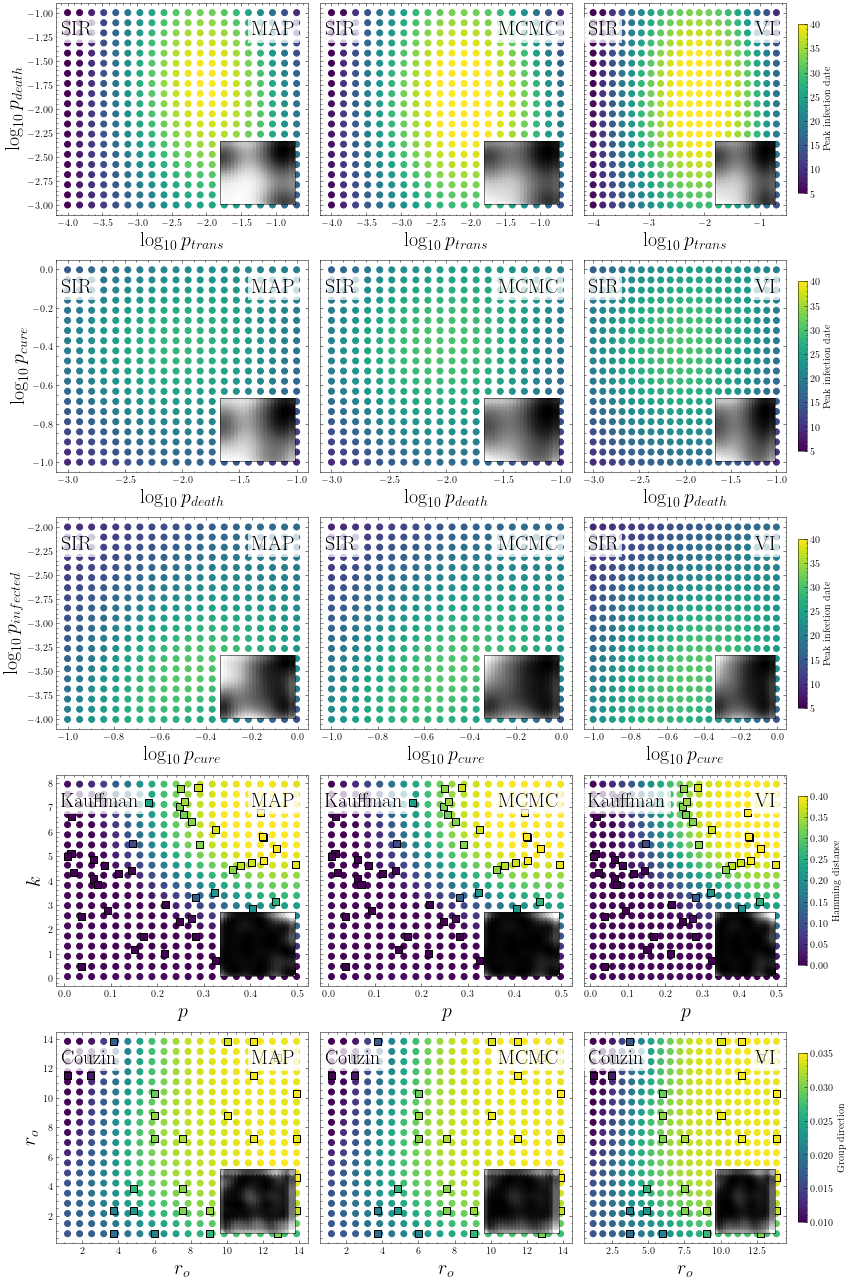

In [7]:
save_fig  = True

clims = {
    'kauffman':[0.0, 0.4],
    'couzin':[0.01, 0.035],
    'sir':[5,40]
}

fig, axes = plt.subplots(5, 3, figsize=(12,18), sharey='row')

for col_idx, fit_method in enumerate(['map','mcmc','vi']):
    row_ctr = 0
    for dataset in datasets:

        with open(f'../data/processed-emulator-inputs/{dataset}.json', 'r') as src:
            json_dict = json.loads(src.read())
            process_names = json_dict['process_names']

        for (mean, variance), X_varying, pair in zip(y_preds[dataset+'_'+fit_method],
                                                     varied_Xs[dataset+'_'+fit_method],
                                                     pairs[dataset]):
            
            ax = axes[row_ctr, col_idx]
            plt.sca(ax)

            Xs = X_varying[:, pair[0]]
            Ys = X_varying[:, pair[1]]
            Zs = mean

            if dataset in clims.keys():
                vmin, vmax = clims[dataset]
            else:
                vmin=None
                vmax=None

            surf = ax.scatter(Xs, Ys, c=Zs, cmap=cmap, vmin=vmin, vmax=vmax)
            plt.xlabel(label_map[process_names[pair[0]]], fontsize=20)
            
            if col_idx == 0:
                plt.ylabel(label_map[process_names[pair[1]]], fontsize=20)
            if col_idx == 2:
                label=response_labels[dataset]
                plt.colorbar(surf, pad=0.05, shrink=0.8,
                    label=label)
            
            plt.text(0.02, 0.85, ds_names[dataset],  ha='left',  fontsize=20, transform=ax.transAxes,
                    bbox=dict(facecolor='w', alpha=0.75, edgecolor='none'))
            plt.text(0.95, 0.85, fit_method.upper(), ha='right', fontsize=20, transform=ax.transAxes,
                    bbox=dict(facecolor='w', alpha=0.75, edgecolor='none'))
            
            if dataset in ['couzin', 'kauffman']:
                xtrue = np.asarray(json_dict['process'])
                ytrue = np.asarray(json_dict['process_response'])
                train = np.asarray(json_dict['train_indices'])
                test  = np.asarray(json_dict['test_indices'])

                ax.scatter(xtrue[test,0], xtrue[test,1],
                           c=ytrue[test], cmap=cmap, edgecolor='k',
                           marker='s', s=50, vmin=vmin, vmax=vmax)
            
            inset = plt.gca().inset_axes([0.65,0.05,0.3,0.3],
                                        transform=plt.gca().transAxes)
            #plt.sca(inset)
            
            variance_norm = variance/variance.max()
            variance_norm = variance_norm - variance_norm.min()
            scat = inset.scatter(Xs,Ys,c=variance_norm, cmap='Greys_r')
            
            '''cax =inset_axes(inset,
                 width="5%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=inset.transAxes,
                 borderpad=0,
                 )
            '''
            #plt.colorbar(scat, ax=inset)
            inset.set_xticks([])
            inset.set_yticks([])

            #plt.colorbar(scat, cax=cax)
            
            row_ctr +=1
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('../figures/surfaces_comparison.png', dpi=400)